In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel,DotProduct,ExpSineSquared
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Read Data
data = pd.read_csv('forestfires.csv')

data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
data = data.drop(['month', 'day'], axis=1)
data.head()

# Calculate Z-scores
data['z_score'] = (data['area'] - data['area'].mean()) / data['area'].std()

# Filter out outliers
cleaned_data = data[abs(data['z_score']) < 3]

In [4]:
X = cleaned_data.iloc[:, 0:9]
X.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8


In [5]:
y = cleaned_data.iloc[:, 10]
y.head()

np.max(y)

np.float64(200.94)

In [6]:
scaler = StandardScaler()

In [7]:
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 1.01304043,  0.57054752, -0.80168858, ..., -1.83604678,
         0.40817226,  1.49492476],
       [ 1.01304043, -0.24474741, -0.00634247, ..., -0.14704903,
        -0.69486042, -1.73763275],
       [ 1.01304043, -0.24474741, -0.00634247, ..., -0.73302784,
        -0.69486042, -1.51469775],
       ...,
       [ 1.01304043, -0.24474741, -1.63318679, ...,  0.40446043,
         1.57248454,  1.49492476],
       [-1.58757545, -0.24474741,  0.68054735, ...,  1.16278595,
        -0.14334408, -0.00988649],
       [ 0.57960445, -1.06004234, -2.01278379, ..., -1.21559863,
        -0.81741961,  0.26878226]])

In [8]:
# Split the data into training and test sets# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1)

In [9]:
# Define the Gaussian Process Regression model with a kernel
# The kernel combines a ConstantKernel and Radial Basis Function (RBF) kernel
# kernel = C(1.0, (1e-2, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
# kernel = (
#     # long-term rising
#     DotProduct(sigma_0=1)
#     # # flunctuate in a year
#     # + 0.1*RBF(length_scale=20) * ExpSineSquared(length_scale=0.1 , periodicity=3)
#     + ExpSineSquared(length_scale=0.1 , periodicity=15)
#     # + 0.1*RBF(length_scale=5) * ExpSineSquared(length_scale=0.1 , periodicity=50)
#     # # minor changes in a year
#     # + 0.1*RationalQuadratic(alpha=1, length_scale=1) + 1 * RBF(length_scale=0.01)
#     # # white noise
#     + WhiteKernel(noise_level=0.01)
# )

kernel = (
    # Long-term trend (Dot product captures a rising trend with the given sigma_0)
    DotProduct(sigma_0=1.0) 
    
    # Seasonal variations (Adjusting length_scale and periodicity for more control)
    + 0.2 * ExpSineSquared(length_scale=10, periodicity=15)  # Adjust length_scale for smoother seasonal variation
    
    # Additional short-term fluctuations (Captures more fine-grained changes)
    + 0.1 * RBF(length_scale=2) * ExpSineSquared(length_scale=0.1, periodicity=50)  # Minor fluctuations
    
    # White noise (Noise level adjusted to prevent overfitting)
    + WhiteKernel(noise_level=0.05)
)
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=1, alpha=1)

In [10]:
# Train the GPR model
model.fit(X_train, y_train)

GaussianProcessRegressor(alpha=1,
                         kernel=DotProduct(sigma_0=1) + 0.447**2 * ExpSineSquared(length_scale=10, periodicity=15) + 0.316**2 * RBF(length_scale=2) * ExpSineSquared(length_scale=0.1, periodicity=50) + WhiteKernel(noise_level=0.05),
                         n_restarts_optimizer=10, random_state=1)

In [11]:
# Make predictions on the test set
y_pred, y_std = model.predict(X_test, return_std=True)

In [12]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("mse", mse)
print("r2", r2)

mse 274.29096897320557
r2 0.005034586806810903


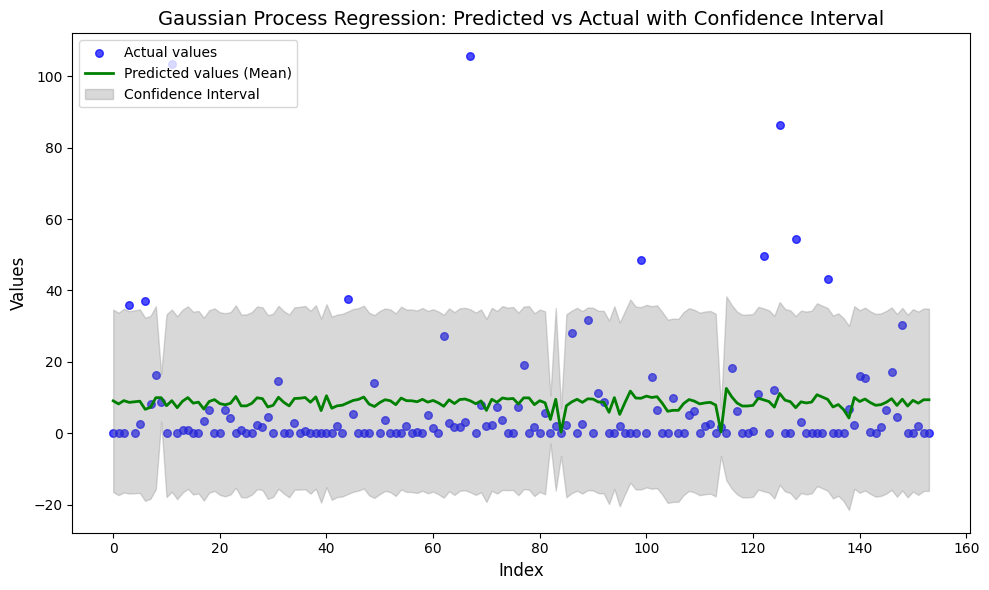

In [13]:
# Plotting
plt.figure(figsize=(10, 6))

# Plotting the scatter plot
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual values', s=30, alpha=0.7)

# Plotting the mean predicted values
plt.plot(range(len(y_pred)), y_pred, color='green', label='Predicted values (Mean)', linestyle='-', linewidth=2)

# Plotting the confidence interval
plt.fill_between(range(len(y_pred)), y_pred - y_std, y_pred + y_std, color='gray', alpha=0.3, label='Confidence Interval')

# Clean up plot appearance
plt.xlabel('Index', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Gaussian Process Regression: Predicted vs Actual with Confidence Interval', fontsize=14)
plt.legend(loc='upper left', fontsize=10)
plt.grid(False)
plt.tight_layout()

plt.show()

In [14]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')

c:\Users\LEGION\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [15]:
print("Cross-Validation R2 Scores:", scores)
print("Mean R2:", scores.mean())

Cross-Validation R2 Scores: [-0.04993786 -0.15032099 -0.02806612 -0.0169478  -0.00405848  0.00335834
 -1.22518576 -0.11325171 -0.02077068 -0.03720951]
Mean R2: -0.1642390559997679


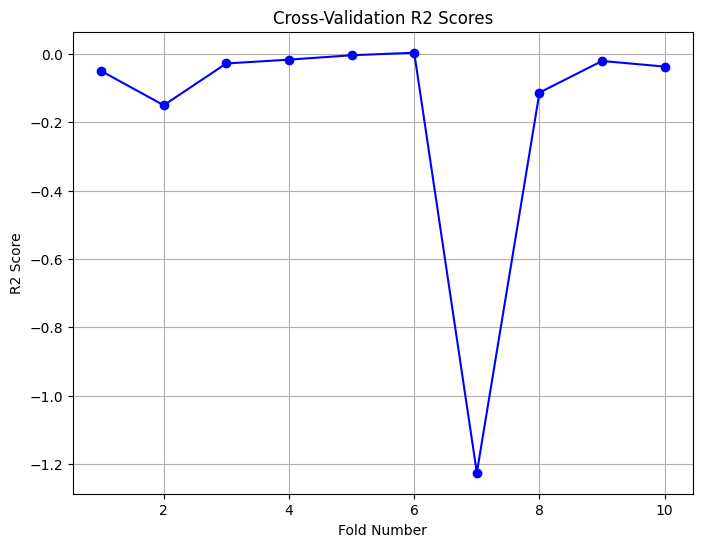

In [16]:
# Plotting the R2 scores
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(scores) + 1), scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation R2 Scores')
plt.xlabel('Fold Number')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()


c:\Users\LEGION\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\LEGION\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpc.py:476: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


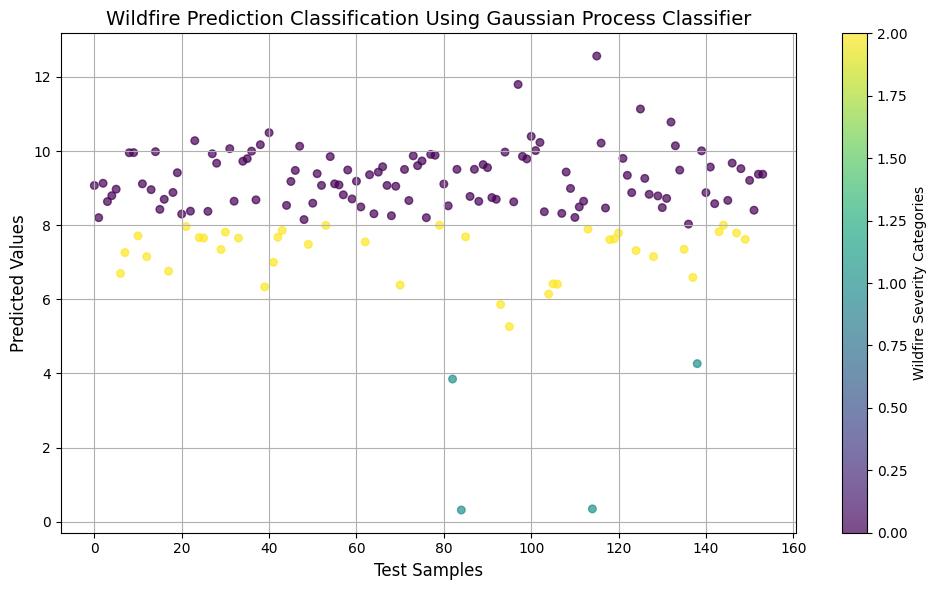

Predicted Categories: ['High' 'High' 'High' 'High' 'High' 'High' 'Medium' 'Medium' 'High' 'High'
 'Medium' 'High' 'Medium' 'High' 'High' 'High' 'High' 'Medium' 'High'
 'High' 'High' 'Medium' 'High' 'High' 'Medium' 'Medium' 'High' 'High'
 'High' 'Medium' 'Medium' 'High' 'High' 'Medium' 'High' 'High' 'High'
 'High' 'High' 'Medium' 'High' 'Medium' 'Medium' 'Medium' 'High' 'High'
 'High' 'High' 'High' 'Medium' 'High' 'High' 'High' 'Medium' 'High' 'High'
 'High' 'High' 'High' 'High' 'High' 'High' 'Medium' 'High' 'High' 'High'
 'High' 'High' 'High' 'High' 'Medium' 'High' 'High' 'High' 'High' 'High'
 'High' 'High' 'High' 'Medium' 'High' 'High' 'Low' 'High' 'Low' 'Medium'
 'High' 'High' 'High' 'High' 'High' 'High' 'High' 'Medium' 'High' 'Medium'
 'High' 'High' 'High' 'High' 'High' 'High' 'High' 'High' 'Medium' 'Medium'
 'Medium' 'High' 'High' 'High' 'High' 'High' 'High' 'Medium' 'Low' 'High'
 'High' 'High' 'Medium' 'Medium' 'Medium' 'High' 'High' 'High' 'Medium'
 'High' 'High' 'High' 'Medium' 

In [17]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Define some categories for wildfire classification (these thresholds can be adjusted)
categories = ["Low", "Medium", "High", "Severe"]

# Example: categorizing based on the value ranges in y_pred
def categorize_wildfire(values):
    """
    Categorize values into wildfire categories based on predefined thresholds.
    """
    categories = ["Low", "Medium", "High", "Severe"]
    thresholds = [0, 5, 8, 15]  # Adjust the thresholds based on the expected range of values
    categorized = []

    for value in values:
        if value <= thresholds[1]:
            categorized.append(categories[0])  # Low
        elif value <= thresholds[2]:
            categorized.append(categories[1])  # Medium
        elif value <= thresholds[3]:
            categorized.append(categories[2])  # High
        else:
            categorized.append(categories[3])  # Severe
    return np.array(categorized)

# Categorize y_pred values
y_pred_categories = categorize_wildfire(y_pred)

# Encode categories as numeric labels for classification
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_pred_categories)

# Reshape y_pred for use in the Gaussian Process Classifier (it should be 2D)
X_train = y_pred.reshape(-1, 1)  # For this example, just use y_pred as the feature
y_train = y_encoded  # Target categories

# Train the Gaussian Process Classifier
kernel = 1.0 * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=kernel)
gpc.fit(X_train, y_train)

# Predict the categories for the given predictions (y_pred)
y_pred_class = gpc.predict(X_train)

# Decode the predicted class labels back to category names
y_pred_class_labels = label_encoder.inverse_transform(y_pred_class)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plotting the predicted categories
plt.scatter(range(len(y_pred)), y_pred, c=y_pred_class, cmap="viridis", s=30, alpha=0.7)
plt.colorbar(label='Wildfire Severity Categories')

# Adding the legend and title
plt.title("Wildfire Prediction Classification Using Gaussian Process Classifier", fontsize=14)
plt.xlabel("Test Samples", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

# Display the predicted categories
print("Predicted Categories:", y_pred_class_labels)


C:\Users\LEGION\AppData\Local\Temp\ipykernel_18864\3994920292.py:114: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax3.boxplot(


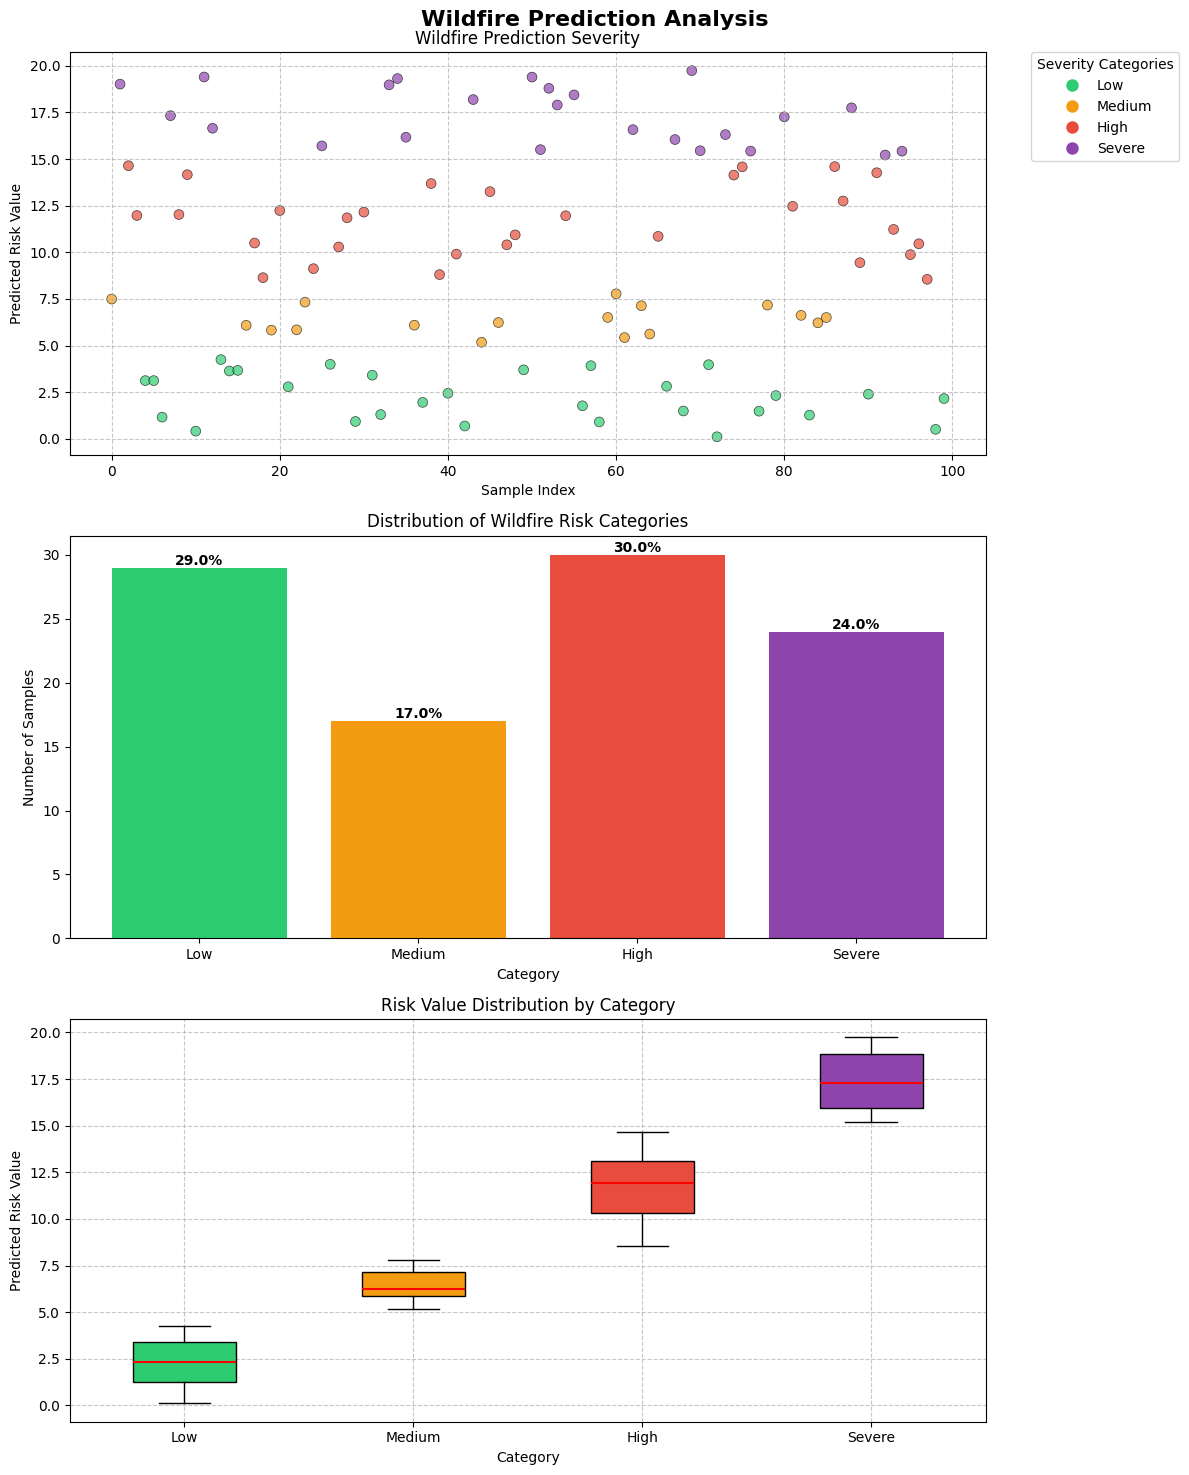

Predicted Categories Distribution:
Low: 29 samples (29.0%)
Medium: 17 samples (17.0%)
High: 30 samples (30.0%)
Severe: 24 samples (24.0%)


In [220]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import LabelEncoder

# Use a built-in Matplotlib style
plt.style.use('default')

# Simulate data if not already defined
np.random.seed(42)
y_pred = np.random.uniform(0, 20, 100)  # Example prediction values

def categorize_wildfire(values):
    """
    Categorize values into wildfire categories based on predefined thresholds.
    """
    categories = ["Low", "Medium", "High", "Severe"]
    thresholds = [0, 5, 8, 15]  # Adjust the thresholds based on the expected range of values
    categorized = []
    for value in values:
        if value <= thresholds[1]:
            categorized.append(categories[0])  # Low
        elif value <= thresholds[2]:
            categorized.append(categories[1])  # Medium
        elif value <= thresholds[3]:
            categorized.append(categories[2])  # High
        else:
            categorized.append(categories[3])  # Severe
    return np.array(categorized)

# Color palette for categories
category_colors = {
    'Low': '#2ecc71',      # Bright green
    'Medium': '#f39c12',   # Warm orange
    'High': '#e74c3c',     # Vibrant red
    'Severe': '#8e44ad'    # Deep purple
}

# Categorize predictions
y_pred_categories = categorize_wildfire(y_pred)

# Encode categories
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_pred_categories)

# Prepare for Gaussian Process Classifier
X_train = y_pred.reshape(-1, 1)
y_train = y_encoded

# Train the Gaussian Process Classifier
kernel = 1.0 * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=kernel)
gpc.fit(X_train, y_train)

# Predict categories
y_pred_class = gpc.predict(X_train)
y_pred_class_labels = label_encoder.inverse_transform(y_pred_class)

# Create a multi-panel visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
fig.suptitle("Wildfire Prediction Analysis", fontsize=16, fontweight='bold')

# 1. Scatter plot with category-based coloring
scatter = ax1.scatter(
    range(len(y_pred)), 
    y_pred, 
    c=[category_colors[cat] for cat in y_pred_categories], 
    s=50, 
    alpha=0.7, 
    edgecolors='black', 
    linewidth=0.5
)
ax1.set_title("Wildfire Prediction Severity", fontsize=12)
ax1.set_xlabel("Sample Index", fontsize=10)
ax1.set_ylabel("Predicted Risk Value", fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', 
           label=category, markerfacecolor=color, markersize=10)
    for category, color in category_colors.items()
]
ax1.legend(handles=legend_elements, title='Severity Categories', 
           loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# 2. Distribution of Categories
category_counts = {cat: list(y_pred_categories).count(cat) for cat in category_colors.keys()}
ax2.bar(
    category_counts.keys(), 
    category_counts.values(), 
    color=category_colors.values()
)
ax2.set_title("Distribution of Wildfire Risk Categories", fontsize=12)
ax2.set_xlabel("Category", fontsize=10)
ax2.set_ylabel("Number of Samples", fontsize=10)

# Add percentage labels on top of each bar
total = sum(category_counts.values())
for i, (category, count) in enumerate(category_counts.items()):
    percentage = count / total * 100
    ax2.text(
        i, count, f'{percentage:.1f}%', 
        ha='center', va='bottom', fontweight='bold'
    )

# 3. Box plot of predictions by category
order = ['Low', 'Medium', 'High', 'Severe']
category_data = [
    y_pred[y_pred_categories == cat] for cat in order
]
box = ax3.boxplot(
    category_data, 
    labels=order, 
    patch_artist=True,
    boxprops=dict(facecolor='lightgray'),
    medianprops=dict(color="red", linewidth=1.5)
)

# Color each box according to category
for patch, color in zip(box['boxes'], [category_colors[cat] for cat in order]):
    patch.set_facecolor(color)

ax3.set_title("Risk Value Distribution by Category", fontsize=12)
ax3.set_xlabel("Category", fontsize=10)
ax3.set_ylabel("Predicted Risk Value", fontsize=10)
ax3.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print detailed category information
print("Predicted Categories Distribution:")
for category, count in category_counts.items():
    percentage = count / total * 100
    print(f"{category}: {count} samples ({percentage:.1f}%)")

c:\Users\LEGION\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpc.py:476: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


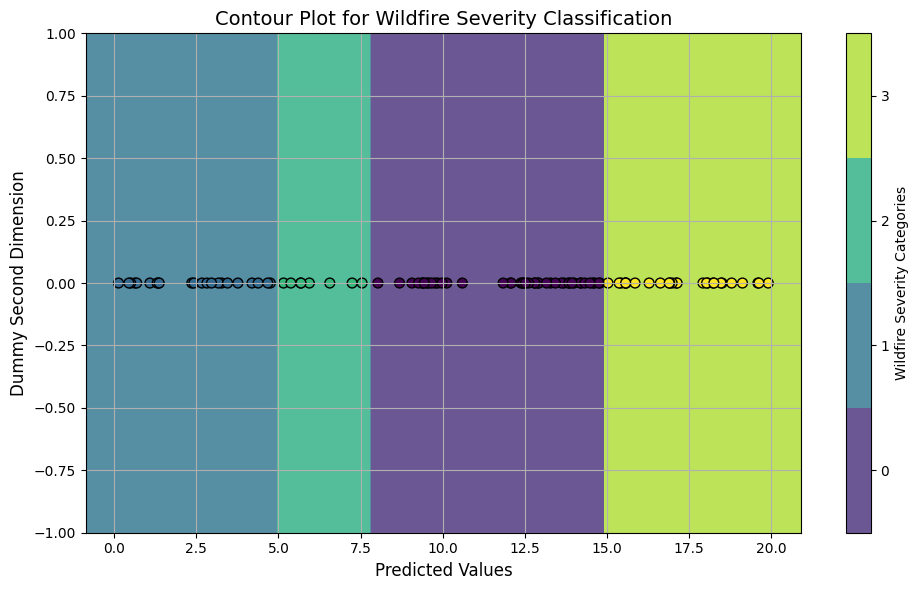

In [21]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
y_pred = np.random.uniform(0, 20, 100)  # Random data for demonstration

# Define some categories for wildfire classification
categories = ["Low", "Medium", "High", "Severe"]

# Categorize values based on predefined thresholds
def categorize_wildfire(values):
    thresholds = [0, 5, 8, 15]
    categorized = []
    for value in values:
        if value <= thresholds[1]:
            categorized.append(categories[0])
        elif value <= thresholds[2]:
            categorized.append(categories[1])
        elif value <= thresholds[3]:
            categorized.append(categories[2])
        else:
            categorized.append(categories[3])
    return np.array(categorized)

# Categorize and encode the data
y_pred_categories = categorize_wildfire(y_pred)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_pred_categories)

# Prepare training data
X_train = y_pred.reshape(-1, 1)
y_train = y_encoded

# Train the Gaussian Process Classifier
kernel = 1.0 * RBF(length_scale=1.0)
gpc = GaussianProcessClassifier(kernel=kernel)
gpc.fit(X_train, y_train)

# Create a 2D grid of input values
x_min, x_max = X_train.min() - 1, X_train.max() + 1
x_grid = np.linspace(x_min, x_max, 500)
y_grid = np.linspace(-1, 1, 50)  # Dummy range for the second dimension
xx, yy = np.meshgrid(x_grid, y_grid)

# Predict class labels for the grid
grid_points = np.c_[xx.ravel(), yy.ravel()]  # Combine into a 2D array for prediction
y_grid_labels = gpc.predict(grid_points[:, 0].reshape(-1, 1)).reshape(xx.shape)

# Plotting the contour
plt.figure(figsize=(10, 6))

# Create contour plot
contour = plt.contourf(
    xx, 
    yy, 
    y_grid_labels, 
    levels=np.arange(-0.5, len(categories) + 0.5, 1), 
    cmap="viridis", 
    alpha=0.8
)

# Add original training points
plt.scatter(X_train, np.zeros_like(X_train), c=y_train, cmap="viridis", edgecolor="k", s=50)

# Add labels and title
plt.colorbar(contour, ticks=range(len(categories)), label='Wildfire Severity Categories')
plt.title("Contour Plot for Wildfire Severity Classification", fontsize=14)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Dummy Second Dimension", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()
